In [299]:
import pandas as pd
import numpy as np

In [300]:
import matplotlib.pyplot as plt

In [301]:
import tensorflow as tf

In [302]:
#this set uses data from Jan 2008 to Jan 2016 as training
train = pd.read_csv("Data/SPY_train_2008_2016.csv")
#this set uses data from Jan 2016 to Dec 2017 as testing
test = pd.read_csv("Data/SPY_test_2016_2017.csv")

In [303]:
#this set uses data from Jan 2008 to Jan 2020 as training
train2 = pd.read_csv("Data/SPY_train_2008_2020.csv")
#this set uses data from Jan 2020 to Jan 2021 as testing: COVID PERIOD
test2 = pd.read_csv("Data/SPY_test_2020_2021.csv")

In [304]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,146.529999,146.990005,143.880005,144.929993,110.811035,204935600
1,2008-01-03,144.910004,145.490005,144.070007,144.860001,110.757507,125133300
2,2008-01-04,143.339996,143.440002,140.910004,141.309998,108.043213,232330900
3,2008-01-07,141.809998,142.229996,140.100006,141.190002,107.951515,234991000
4,2008-01-08,142.080002,142.899994,138.440002,138.910004,106.208267,326365700


In [305]:
#features:
"""
CCI: CCI5, CCI10, CCI20
MACD: MACD, MACD_historical, MACD_signal
"""

'\nCCI: CCI5, CCI10, CCI20\nMACD: MACD, MACD_historical, MACD_signal\n'

In [306]:
ndays1 = 5
ndays2 = 10
ndays3 = 20

In [309]:
def get_CCI(data, ndays):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3 
    moving_avg = typical_price.rolling(ndays).mean()
    mean_deviation = typical_price.rolling(ndays).apply(lambda x: pd.Series(x).mad())
    CCI = (typical_price - moving_avg) / (0.015 * mean_deviation) 
    return CCI

C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


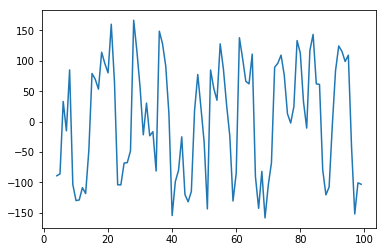

In [310]:
plt.plot(get_CCI(train, ndays1)[:100])

In [311]:
#MACD calculations
"""
MACD Line: (12-day EMA - 26-day EMA)

Signal Line: 9-day EMA of MACD Line

MACD Histogram: MACD Line - Signal Line
"""

'\nMACD Line: (12-day EMA - 26-day EMA)\n\nSignal Line: 9-day EMA of MACD Line\n\nMACD Histogram: MACD Line - Signal Line\n'

In [312]:
def get_macd_indicators(data):
    moving_avg26 = data['Close'].rolling(26).mean()
    exp_moving_avg12 = data['Close'].ewm(span=12, adjust=False).mean()
    macd = exp_moving_avg12 - moving_avg26
    signal = macd.rolling(9).mean()
    macd_hist = macd - signal
    return macd, signal, macd_hist

In [313]:
macd, signal, macd_hist = get_macd_indicators(train)

In [314]:
cci1 = get_CCI(train, ndays1)

C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


Text(0, 0.5, 'MACD Signal')

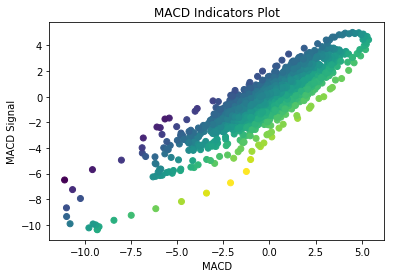

In [318]:
plt.scatter(macd, signal, c=macd_hist)
plt.title("MACD Indicators Plot")
plt.xlabel("MACD")
plt.ylabel("MACD Signal")

Text(0, 0.5, 'MACD')

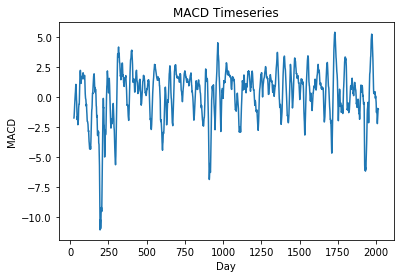

In [320]:
plt.plot(macd)
plt.title("MACD Timeseries")
plt.xlabel("Day")
plt.ylabel("MACD")

Text(0, 0.5, 'MACD signal')

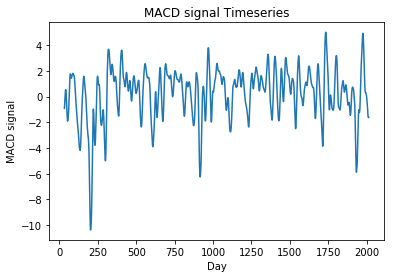

In [321]:
plt.plot(signal)
plt.title("MACD signal Timeseries")
plt.xlabel("Day")
plt.ylabel("MACD signal")

Text(0, 0.5, 'MACD histogram')

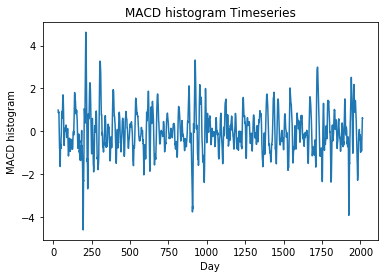

In [322]:
plt.plot(macd_hist)
plt.title("MACD histogram Timeseries")
plt.xlabel("Day")
plt.ylabel("MACD histogram")

In [323]:
#get all features

In [345]:
price_features = ["High", "Low", "Close"]
CCI_features = ["CCI5", "CCI10", "CCI20"]
MACD_features = ["MACD", "MACDsignal", "MACDhist"]
return_features = ["returns1", "returns2", "returns3"]

In [346]:
#function to convert features to images
def get_train_images(train_features):
    train_images = []
    for i in range(len(train_features)-9):
        image1 = train_features[price_features][i:i+10].T
        image2 = train_features[CCI_features][i:i+10].T
        image3 = train_features[MACD_features][i:i+10].T
        #image4 = train_features[return_features][i:i+10].T
        

        image_total1 = np.append(arr=image1.values.reshape((3, 10, 1)), values=image2.values.reshape((3, 10, 1)), axis=2)
        image_total2 = np.append(arr=image_total1, values=image3.values.reshape((3, 10, 1)), axis=2)
        #image_total3 = np.append(arr=image_total2, values=image4.values.reshape((3, 10, 1)), axis=2)

        train_images.append(image_total2)
        
    return train_images

In [347]:
def get_features(train):
    train_features = train.copy()
    train_features["CCI5"] = get_CCI(train_features, 5)
    train_features["CCI10"] = get_CCI(train_features, 10)
    train_features["CCI20"] = get_CCI(train_features, 20)

    train_features["MACD"], train_features["MACDsignal"], train_features["MACDhist"] = get_macd_indicators(train_features)
    
    #Calculate future returns features
    close_next = train_features["Close"].shift(-1)
    returns = (close_next - train_features["Close"]) / (train_features["Close"])
    
    #convert futures return to boolean
    train_features["y"] = np.sign(returns).replace(-1, 0)
    
    #train_features["returns1"] = returns.shift(1)
    #train_features["returns2"] = returns.shift(2)
    #train_features["returns3"] = returns.shift(3)
    
    train_features = train_features.dropna()
    train_date = train_features["Date"]
    train_labels = train_features["y"]
    train_features = train_features[price_features + CCI_features + MACD_features]
    
    #convert train_features and train_labels to train_images in tf format
    train_images = tf.stack(get_train_images(train_features))
    train_labels = tf.stack(train_labels[9:])
    
    
    return train_date[9:], train_images, train_labels

In [373]:
#Jan 2008 - Jan 2016
train_date1, train_images1, train_labels1 = get_features(train)

C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


In [374]:
#Jan 2016 - Dec 2017
test_date1, test_images1, test_labels1 = get_features(test)

C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


In [375]:
#Jan 2008 - Jan 2020
train_date2, train_images2, train_labels2 = get_features(train2)

C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


In [376]:
#Jan 2020 - Jan 2021
test_date2, test_images2, test_labels2 = get_features(test2)

C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


In [377]:
from tensorflow.keras import datasets, layers, models

In [378]:
def get_model():
    model = models.Sequential()
    model.add(layers.ZeroPadding2D(
        padding=1, 
        input_shape=(3, 10, 3),
    ))

    model.add(layers.Conv2D(
        16, (3, 3), activation='relu',
        activity_regularizer=tf.keras.regularizers.L2(0.01)
    ))

    model.add(layers.Conv2D(
        32, (3, 2), activation='relu',
        activity_regularizer=tf.keras.regularizers.L2(0.01)
    ))

    model.add(layers.Flatten())
    #model.add(layers.Dense(64, activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(layers.Dense(2))
    model.build()
    model.summary()
    
    return model

### Train model on 95% of train1, validate on 5% of train1, evaluate on test1

In [380]:
#lets split training set into main training set and validation set
main_train_images1 = train_images1[:int(0.95*len(train_images1))]
main_labels = train_labels[:int(0.95*len(train_images1))]

val_train_images1 = train_images1[int(0.95*len(train_images1)):]
val_labels = train_labels[int(0.95*len(train_images1)):]

In [382]:
model1 = get_model()
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(main_train_images1, main_labels, epochs=20, validation_data=(val_train_images1, val_labels))

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_26 (ZeroPaddi (None, 5, 12, 3)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 3, 10, 16)         448       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 1, 9, 32)          3104      
_________________________________________________________________
flatten_27 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 578       
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
59/59 [==============================] - 1s 5ms/step - loss: 2603.2322 - accuracy: 0.4848 - val_loss: 498.

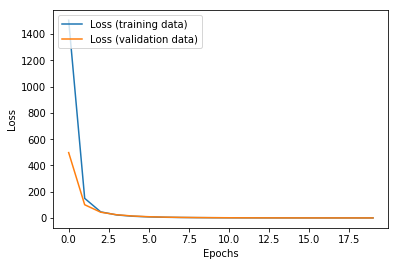

In [383]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

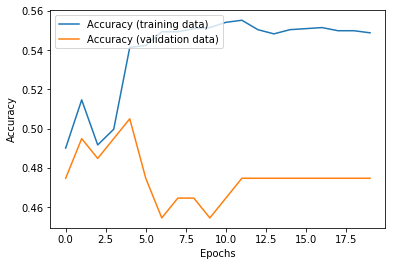

In [384]:
# Plot history: MAE
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

In [385]:
results = model1.evaluate(test_images1, test_labels1)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 1ms/step - loss: 0.7737 - accuracy: 0.5522
test loss, test acc: [0.7736659646034241, 0.552173912525177]


### Train model on train2, validate and evaluate on test2

In [387]:
model2 = get_model()
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(train_images2, train_labels2, epochs=20, validation_data=(test_images2, test_labels2))

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_28 (ZeroPaddi (None, 5, 12, 3)          0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 3, 10, 16)         448       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 9, 32)          3104      
_________________________________________________________________
flatten_29 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 578       
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 4ms/step - loss: 4547.8509 - accuracy: 0.4983 - val_loss: 577.

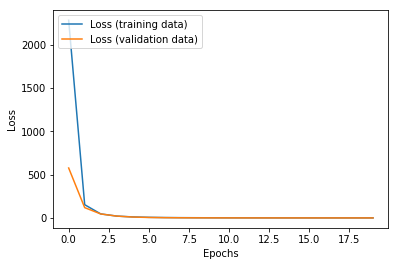

In [388]:
# Plot history: MAE
plt.plot(history2.history['loss'], label='Loss (training data)')
plt.plot(history2.history['val_loss'], label='Loss (validation data)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

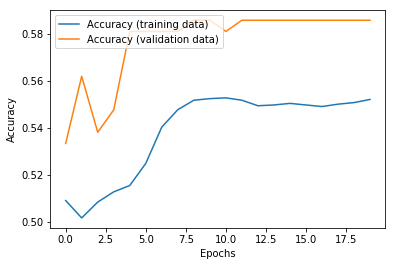

In [389]:
# Plot history: MAE
plt.plot(history2.history['accuracy'], label='Accuracy (training data)')
plt.plot(history2.history['val_accuracy'], label='Accuracy (validation data)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

In [390]:
results = model1.evaluate(test_images2, test_labels2)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 1ms/step - loss: 0.7111 - accuracy: 0.5857
test loss, test acc: [0.711091160774231, 0.5857142806053162]
